In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
import pickle

In [2]:
data = pd.read_csv('./insurance.csv')

In [3]:
clean_data = {'sex': {'male' : 0 , 'female' : 1} ,
                 'smoker': {'no': 0 , 'yes' : 1},
                   'region' : {'northwest':0, 'northeast':1,'southeast':2,'southwest':3}
               }
data_copy = data.copy()
data_copy.replace(clean_data, inplace=True)

In [4]:
data_pre = data_copy.copy()

tempBmi = data_pre.bmi
tempBmi = tempBmi.values.reshape(-1,1)
data_pre['bmi'] = StandardScaler().fit_transform(tempBmi)

tempAge = data_pre.age
tempAge = tempAge.values.reshape(-1,1)
data_pre['age'] = StandardScaler().fit_transform(tempAge)

tempExpenses = data_pre.expenses
tempExpenses = tempExpenses.values.reshape(-1,1)
data_pre['expenses'] = StandardScaler().fit_transform(tempExpenses)

data_pre.head()

,age,sex,bmi,children,smoker,region,expenses
0,-1.438764,1,-0.453646,0,1,3,0.298583
1,-1.509965,0,0.514186,1,0,2,-0.953689
2,-0.797954,0,0.382954,3,0,2,-0.728675
3,-0.441948,0,-1.306650,0,0,0,0.719843
4,-0.513149,0,-0.289606,0,0,0,-0.776802


In [5]:
X = data_pre.drop('expenses',axis=1).values
y = data_pre['expenses'].values.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=100)

In [6]:
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

LinearRegression()

In [7]:
cv_linear = cross_val_score(estimator = linear_reg, X = X, y = y, cv = 10)
y_pred = linear_reg.predict(X_test)
r2_score_test = r2_score(y_test,y_pred)
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print('CV Linear Regression : {0:.3f}'.format(cv_linear.mean()))
print('R2_score (test) : {0:.3f}'.format(r2_score_test))
print('RMSE : {0:.3f}'.format(rmse))

CV Linear Regression : 0.745
R2_score (test) : 0.794
RMSE : 0.469


In [8]:
svr = SVR()

In [9]:
parameters =  { 'kernel' : ['rbf', 'sigmoid'],
                 'gamma' : [0.001, 0.01, 0.1, 1, 'scale'],
                 'tol' : [0.0001],
                 'C': [0.001, 0.01, 0.1, 1, 10, 100] }
svr_grid = GridSearchCV(estimator=svr, param_grid=parameters, cv=10, verbose=4, n_jobs=-1)
svr_grid.fit(X_train, y_train.ravel())

Fitting 10 folds for each of 60 candidates, totalling 600 fits


GridSearchCV(cv=10, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'gamma': [0.001, 0.01, 0.1, 1, 'scale'],
                         'kernel': ['rbf', 'sigmoid'], 'tol': [0.0001]},
             verbose=4)

In [10]:
svr = SVR(C=10, gamma=0.1, tol=0.0001)
svr.fit(X_train, y_train.ravel())
print(svr_grid.best_estimator_)
print(svr_grid.best_score_)

SVR(C=100, gamma=0.01, tol=0.0001)
0.8206113992763451


In [11]:
cv_svr = svr_grid.best_score_
y_pred_svr = svr.predict(X_test)
r2_score_svr = r2_score(y_test, y_pred_svr)

rmse_svr = (np.sqrt(mean_squared_error(y_test, y_pred_svr)))

print('CV : {0:.3f}'.format(cv_svr.mean()))
print('R2 score (test) : {0:.3f}'.format(r2_score_svr))
print('RMSE : {0:.3f}'.format(rmse_svr))

CV : 0.821
R2 score (test) : 0.881
RMSE : 0.357


In [12]:
steps = [ ('scalar', StandardScaler()),
        ('poly', PolynomialFeatures(degree=2)),
        ('model', Ridge())]

ridge_pipe = Pipeline(steps)

In [13]:
parameters = { 'model__alpha': [1e-15, 1e-10, 1e-8, 1e-3, 1e-2,1,2,5,10,20,25,35, 43,55,100], 'model__random_state' : [42]}
reg_ridge = GridSearchCV(ridge_pipe, parameters, cv=10)
reg_ridge = reg_ridge.fit(X_train, y_train.ravel())

C:\Users\p.sudesh.kanojia\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.99626e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\p.sudesh.kanojia\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.40431e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


In [14]:
reg_ridge.best_estimator_, reg_ridge.best_score_

(Pipeline(steps=[('scalar', StandardScaler()), ('poly', PolynomialFeatures()),
                 ('model', Ridge(alpha=25, random_state=42))]),
 0.8172992820111604)

In [15]:
ridge = Ridge(alpha=20, random_state=42)
ridge.fit(X_train, y_train)
cv_ridge = reg_ridge.best_score_

y_pred_ridge = ridge.predict(X_test)
r2_score_ridge= r2_score(y_test, y_pred_ridge)

rmse_ridge = (np.sqrt(mean_squared_error(y_test, y_pred_ridge)))
print('CV : {0:.3f}'.format(cv_ridge.mean()))
print('R2 score (test) : {0:.3f}'.format(r2_score_ridge))
print('RMSE : {0:.3f}'.format(rmse_ridge))

CV : 0.817
R2 score (test) : 0.778
RMSE : 0.487


In [16]:
reg_rf = RandomForestRegressor()
parameters = { 'n_estimators':[600,1000,1200],
             'max_features': ["auto"],
             'max_depth':[40,50,60],
             'min_samples_split': [5,7,9],
             'min_samples_leaf': [7,10,12],
             'criterion': ['mse']}

reg_rf_grid = GridSearchCV(estimator=reg_rf, param_grid=parameters, cv=10, n_jobs=-1)
reg_rf_grid = reg_rf_grid.fit(X_train, y_train.ravel())

In [17]:
reg_rf_grid.best_score_, reg_rf_grid.best_estimator_

(0.8413661480764766,
 RandomForestRegressor(max_depth=50, min_samples_leaf=12, min_samples_split=7,
                       n_estimators=1000))

In [18]:
rf_reg = RandomForestRegressor(max_depth=50, min_samples_leaf=12, min_samples_split=5,
                       n_estimators=600)
rf_reg.fit(X_train, y_train.ravel())

RandomForestRegressor(max_depth=50, min_samples_leaf=12, min_samples_split=5,
                      n_estimators=600)

In [19]:
cv_rf = reg_rf_grid.best_score_
y_pred_rf = rf_reg.predict(X_test)

r2_score_rf = r2_score(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print('CV : {0:.3f}'.format(cv_rf.mean()))
print('R2 score (test) : {0:.3f}'.format(r2_score_rf))
print('RMSE : {0:.3f}'.format(rmse_rf))

CV : 0.841
R2 score (test) : 0.896
RMSE : 0.334


In [20]:
models = [('Linear Regression', rmse, r2_score_test, cv_linear.mean()),
          ('Ridge Regression', rmse_ridge, r2_score_ridge, cv_ridge.mean()),
          ('Support Vector Regression', rmse_svr, r2_score_svr, cv_svr.mean()),
          ('Random Forest Regression', rmse_rf, r2_score_rf, cv_rf.mean())   
         ]

In [21]:
predict = pd.DataFrame(data = models, columns=['Model', 'RMSE', 'R2_Score(test)', 'Cross-Validation'])
predict

,Model,RMSE,R2_Score(test),Cross-Validation
0,Linear Regression,0.469299,0.794176,0.744544
1,Ridge Regression,0.487098,0.778268,0.817299
2,Support Vector Regression,0.356766,0.881051,0.820611
3,Random Forest Regression,0.334199,0.895622,0.841366


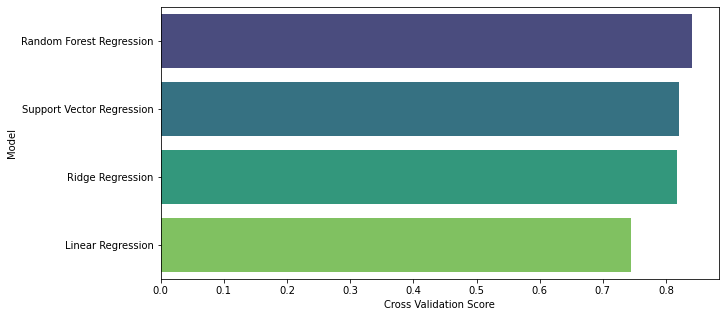

In [22]:
plt.figure(figsize=(10,5))
predict.sort_values(by=['Cross-Validation'], ascending=False, inplace=True)
sns.barplot(x='Cross-Validation', y='Model',data = predict, palette='viridis')
plt.xlabel('Cross Validation Score')
plt.ylabel('Model')
plt.show()

In [23]:
data_copy.head()

,age,sex,bmi,children,smoker,region,expenses
0,19,1,27.9,0,1,3,16884.92
1,18,0,33.8,1,0,2,1725.55
2,28,0,33.0,3,0,2,4449.46
3,33,0,22.7,0,0,0,21984.47
4,32,0,28.9,0,0,0,3866.86


In [24]:
X_ = data_copy.drop('expenses',axis=1).values
y_ = data_copy['expenses'].values.reshape(-1,1)

from sklearn.model_selection import train_test_split
X_train_, X_test_, y_train_, y_test_ = train_test_split(X_,y_,test_size=0.2, random_state=100)

In [25]:
rf_reg = RandomForestRegressor(max_depth=50, min_samples_leaf=12, min_samples_split=5,
                       n_estimators=600)
rf_reg.fit(X_train_, y_train_.ravel())

RandomForestRegressor(max_depth=50, min_samples_leaf=12, min_samples_split=5,
                      n_estimators=600)

In [26]:
y_pred_rf_train_ = rf_reg.predict(X_train_)
r2_score_rf_train_ = r2_score(y_train_, y_pred_rf_train_)

y_pred_rf_test_ = rf_reg.predict(X_test_)
r2_score_rf_test_ = r2_score(y_test_, y_pred_rf_test_)

print('R2 score (train) : {0:.3f}'.format(r2_score_rf_train_))
print('R2 score (test) : {0:.3f}'.format(r2_score_rf_test_))

R2 score (train) : 0.879
R2 score (test) : 0.896


In [27]:
filename = 'rf_tuned.pkl'
pickle.dump(rf_reg, open(filename, 'wb'))

In [28]:
load_model = pickle.load(open(filename, 'rb'))
model_score = load_model.score(X_test_, y_test_)
model_score

0.896485347381163